## Exploring `stable-diffusion` type models (`HuggingFace`)

After some experiments with DALL-E, it did not seem to have such amazing quality, so Midjourney and Stable Diffusion shall serve as better options.
I'll be checking open-source Stable Diffusion versions, hosted on HuggingFace. 
Use cases will includ text-to-image, and img2img pipelines

**Disclaimer**: for now all models are running on CPU, hence the very slow inference. 

In [1]:
from diffusers import (
    
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline, 
    StableDiffusionUpscalePipeline, 
    StableDiffusionInpaintPipeline, 
    StableDiffusionInstructPix2PixPipeline,
)

import requests
from PIL import Image, ImageOps
from io import BytesIO

import torch

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


### 1. text2img experiments

Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img

Models worth using:
1. `runwayml/stable-diffusion-v1-5`
2. `CompVis/stable-diffusion-v1-4`
3. `stabilityai/stable-diffusion-2`
4. `stabilityai/stable-diffusion-2-base`
4. `stabilityai/stable-diffusion-2-1`
5. `stabilityai/stable-diffusion-2-1-base`


In [10]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16 --> if CUDA available

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [13]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0] 

  0%|          | 0/50 [00:00<?, ?it/s]

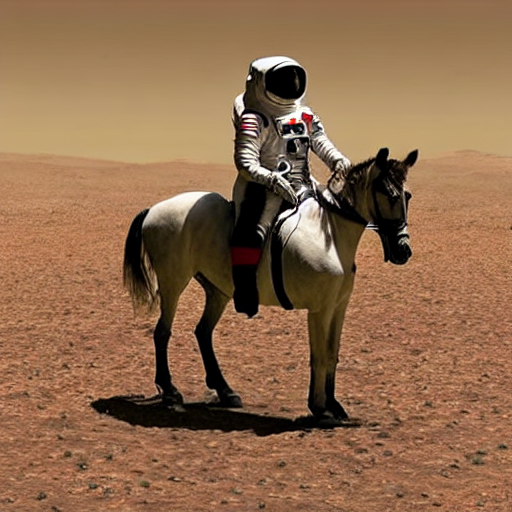

In [14]:
image

Now try with only 20 denoising steps instead of the default value of 50

In [15]:
image_lower_qual = pipe(prompt, num_inference_steps = 20).images[0] 

  0%|          | 0/20 [00:00<?, ?it/s]

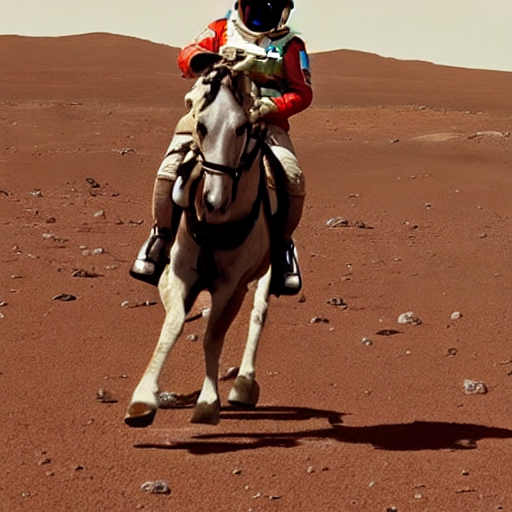

In [16]:
image_lower_qual

### 2. img2img experiments

The `StableDiffusionImg2ImgPipeline` lets you pass a text prompt and an initial image to condition the generation of new images using Stable Diffusion.

Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/img2img

In [18]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


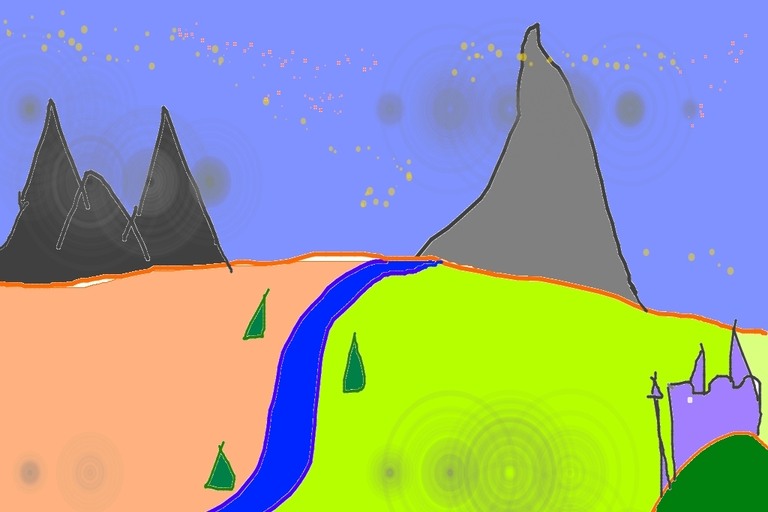

In [19]:
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

init_image

In [20]:
prompt = "A fantasy landscape, trending on artstation"
image = pipe(prompt=prompt, image=init_image, strength=0.7, guidance_scale=7.5, num_inference_steps = 20).images[0] 

  0%|          | 0/14 [00:00<?, ?it/s]

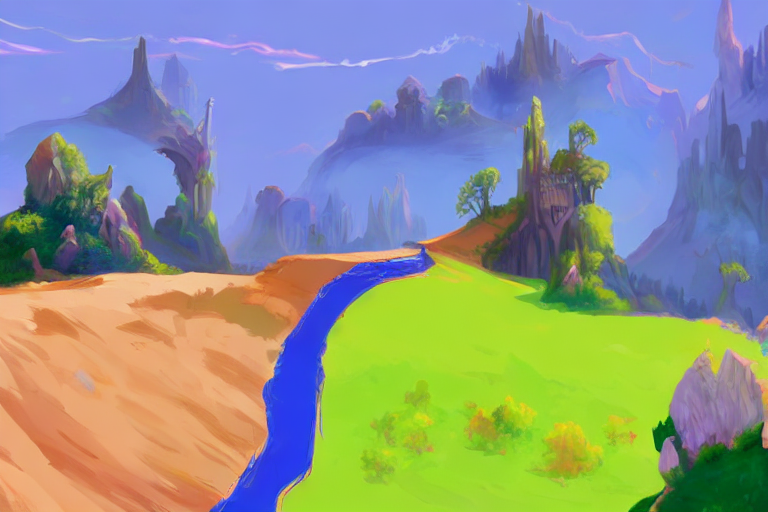

In [25]:
image

### 3. inpaint experiments

The `StableDiffusionInpaintPipeline` lets you edit specific parts of an image by providing a mask and a text prompt using Stable Diffusion.

Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint

Models worth looking at:
1. `stabilityai/stable-diffusion-2-inpainting`
2. `runwayml/stable-diffusion-inpainting`

In [2]:
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

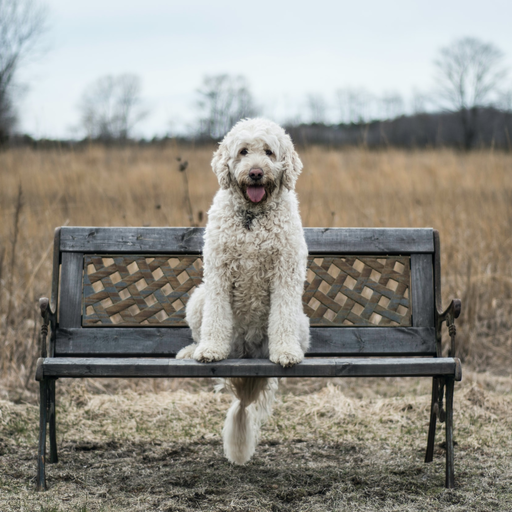

In [3]:
init_image

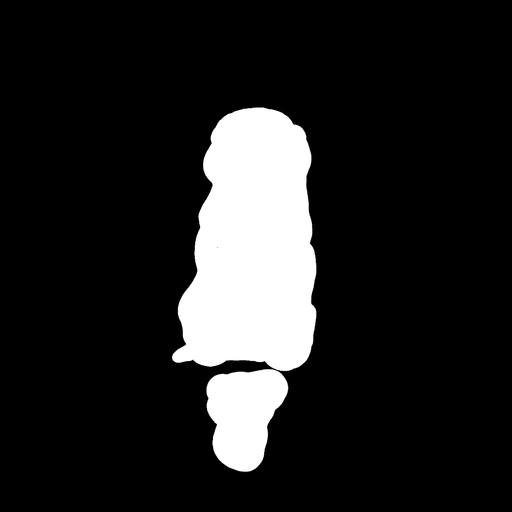

In [4]:
mask_image

In [7]:
model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [10]:
prompt = "a yellow cat sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image, num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

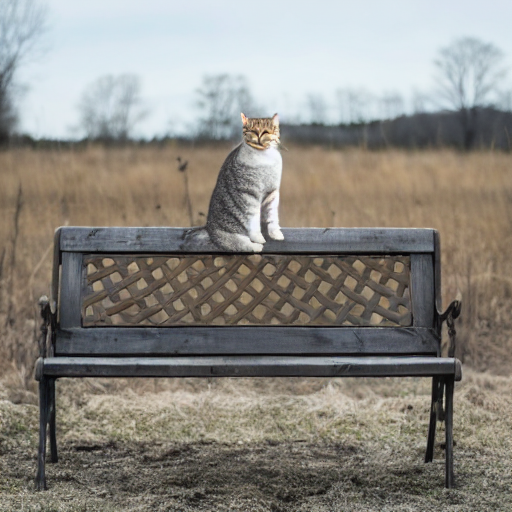

In [11]:
image

Same prompt but 50 steps

  0%|          | 0/50 [00:00<?, ?it/s]

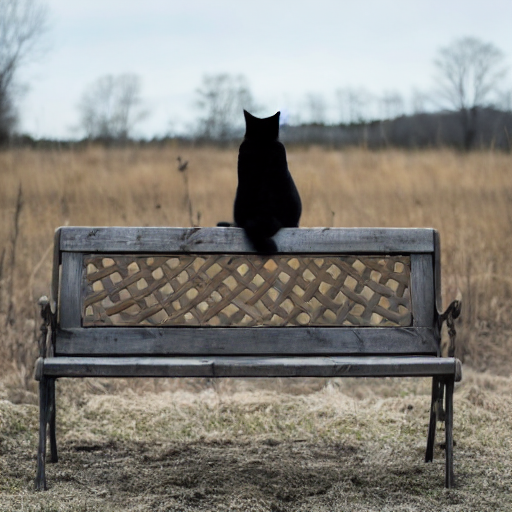

In [12]:
prompt = "a yellow cat sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image, num_inference_steps=50).images[0]
image

It's not yellow, but it's acceptably realistic!

### 4. upscaling experiments

`StableDiffusionUpscalePipeline` can be used to enhance the resolution of input images by a factor of 4.

Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/upscale

Models worth looking at:
1. `stabilityai/stable-diffusion-x4-upscaler`

In [3]:
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id) #, revision="fp16", torch_dtype=torch.float16 --> with CUDA

In [4]:
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))

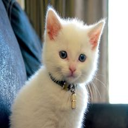

In [5]:
low_res_img

In [6]:
prompt = "a white cat"
upscaled_image = pipeline(prompt=prompt, image=low_res_img, num_inference_steps = 20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

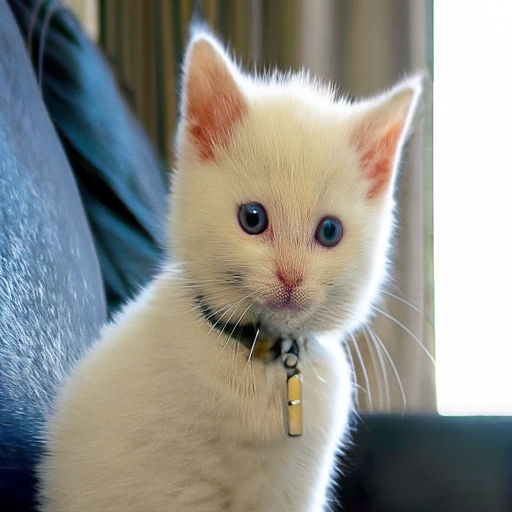

In [7]:
upscaled_image

### 5. pix2pix experiments

A method (`StableDiffusionInstructPix2PixPipeline`) for editing images from human instructions: given an input image and a written instruction that tells the model what to do, the model follows these instructions to edit the image.

Documentation: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/pix2pix

Models worth looking at:
1. `timbrooks/instruct-pix2pix` (https://huggingface.co/timbrooks/instruct-pix2pix)

In [7]:
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


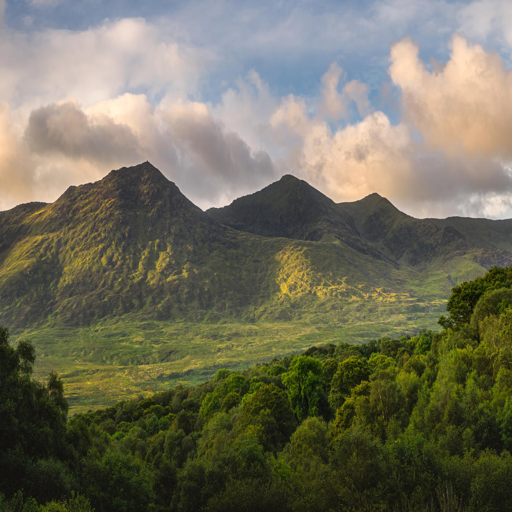

In [8]:
url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"


def download_image(url):
    image = Image.open(requests.get(url, stream=True).raw)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


orig_image = download_image(url)

orig_image

In [10]:
prompt = "make the mountains snowy"
image = pipe(prompt, image=orig_image, num_inference_steps=20, image_guidance_scale=1.5, guidance_scale=7).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
image

Flower use case

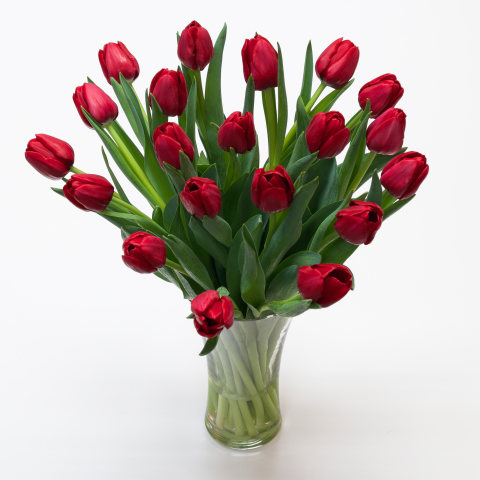

In [9]:
red_tulips = download_image('https://s3.amazonaws.com/cdn.tulips.com/images/large/20-Stems-Red-Tulips.jpg')
red_tulips

In [ ]:
prompt = "swap red tulips with white tulips"
image = pipe(prompt, image=red_tulips, num_inference_steps=20, image_guidance_scale=1.5, guidance_scale=7).images[0]
image

In [ ]:
prompt = "swap red tulips with white roses"
image = pipe(prompt, image=red_tulips, num_inference_steps=20, image_guidance_scale=1.5, guidance_scale=7).images[0]
image

In [ ]:
prompt = "add roses and chrysanthemum"
image = pipe(prompt, image=red_tulips, num_inference_steps=20, image_guidance_scale=1.5, guidance_scale=7).images[0]
image